In [13]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from funcs.stats import get_stats
from funcs.xarray_tools import find_cor_ts
from funcs.plotting import map_grid_clean
from constants.colors import loc_colors

In [20]:
fps = list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*_v2.nc'))
# fps = [fp for fp in fps if 'lowman' not in fp.stem]
dss = {fp.stem.replace('_v2',''): xr.open_dataset(fp) for fp in fps}

fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/model')

In [4]:
# for stem, ds in dss.items():
#     for var in ['model_sd', 'model_melt', 'model_swe']:
#         sub_fig_dir = fig_dir.joinpath(var)
#         sub_fig_dir.mkdir(exist_ok = True)
#         if sub_fig_dir.joinpath(f'{stem}_{var}.png').exists(): continue

#         ds[var].mean('model_time').plot()
#         plt.gca().set_title(stem)
#         plt.savefig(sub_fig_dir.joinpath(f'{stem}_{var}.png'))
#         plt.close()


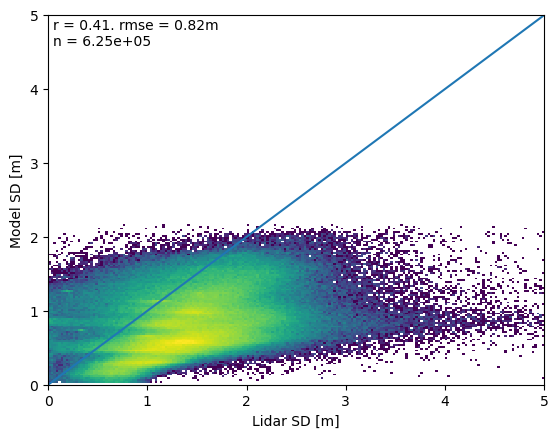

In [4]:
# lidar = []
# model = []
# for stem, ds in dss.items():
#     if 'sd' not in ds.data_vars: continue
#     sub_fig_dir = fig_dir.joinpath('lidar_model_sd')
#     sub_fig_dir.mkdir(exist_ok = True)
#     for time in ds['sd'].time.values:
#         fig, axes= plt.subplots(2, 1, figsize = (12, 8))
#         ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[0], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
#         ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[1], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
        
#         model.extend(ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
#         lidar.extend(ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
        
#         axes[0].set_title('Model Snow Depth')
#         axes[1].set_title('Lidar Snow Depth')
#         plt.tight_layout()
#         plt.savefig(sub_fig_dir.joinpath(f'{stem}_{pd.to_datetime(time).date()}' ))
#         plt.close()
# plt.hist2d(lidar, model, bins = 200, range=[[0,5],[0,5]], norm=mpl.colors.LogNorm())
# plt.plot([0, 5], [0,5])
# plt.xlabel('Lidar SD [m]')
# plt.ylabel('Model SD [m]')
# rmse, r, n = get_stats(lidar, model)
# plt.text(0.01, 0.99, f'r = {r:.2f}. rmse = {rmse:.2f}m\nn = {n:.2e}', transform = plt.gca().transAxes, ha = 'left', va = 'top')
# plt.savefig(sub_fig_dir.joinpath('overall_sd_lidar_compare.png'))

In [21]:
var_fig_dir = fig_dir.joinpath('cor_model')
var_fig_dir.mkdir(exist_ok = True)

from tqdm import tqdm

for stem, ds in dss.items():
    print(stem)
    if 'VV' not in ds.pol: continue
    ts = find_cor_ts(ds)
    name = loc_colors[stem]['name']
    sub_fig_dir = var_fig_dir.joinpath(stem)
    sub_fig_dir.mkdir(exist_ok = True)

    # ds = ds.where((ds['tree_perc'] < 10) & (ds["inc"] < np.deg2rad(60)))
    ds = ds.where(ds["inc"] < np.deg2rad(75))
    for heading, t1, t2 in tqdm(ts):
        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        if (t2 - t1).days > 13: continue
        cor = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'VV')
        model = ds[['model_sd', 'model_melt', 'model_swe']].sel(model_time = slice(t1, t2), heading = heading)

        cor = cor.where((~model['model_sd'].isel(model_time = 0).isnull())).dropna('x', how = 'all').dropna('y', how = 'all')
        model = model.where((~cor.isnull())).dropna('x', how = 'all').dropna('y', how = 'all')

        # d_sd = model['model_sd'].isel(model_time = -1) - ds['model_sd'].isel(model_time = 0)
        d_swe = model['model_swe'].isel(model_time = -1) - model['model_swe'].isel(model_time = 0)
        cum_melt = model['model_melt'].sum('model_time')
        swe = model['model_swe'].isel(model_time = -1)

        # if sub_fig_dir.joinpath(f'{name}_{t1.date()}_{t2.date()}.png').exists(): continue

        fig, axes = plt.subplots(2, 2, figsize = (12, 8))
        axer = axes.ravel()
        cor.plot(ax = axer[0], cmap = 'Greys_r', cbar_kwargs = {'label': ''})
        model['model_swe'].isel(model_time = -1).plot(ax = axer[1], cmap = 'Blues', cbar_kwargs = {'label': ''}, vmin = 0, vmax = 1)
        d_swe.plot(ax = axer[2], cmap = 'RdBu', cbar_kwargs = {'label': ''}, vmin = -0.7, vmax = 0.7)
        cum_melt.plot(ax = axer[3], cmap = 'Reds', cbar_kwargs = {'label': ''}, vmin = 0, vmax = 0.2)
        map_grid_clean(axes)
        for ax, title in zip(axer, ['Coherence []', 'SWE [m]', 'dSWE [m]', 'Cumulative Melt [m]']): ax.set_title(title)
        fig.suptitle(f'{name} - {t1.date()} to {t2.date()}')
        plt.savefig(sub_fig_dir.joinpath(f'{name}_{t1.date()}_{t2.date()}.png'))
        plt.close()

stlake


KeyboardInterrupt: 

In [22]:
cors = np.array([])
dswes = np.array([])
cummelts = np.array([])
swes = np.array([])

from tqdm import tqdm

for stem, ds in dss.items():
    if stem == 'lowman': continue
    print(stem)
    if 'VV' not in ds.pol: continue
    ts = find_cor_ts(ds)
    name = loc_colors[stem]['name']

    ds = ds.where((ds['tree_perc'] < 10) & (ds["inc"] < np.deg2rad(60)))
    # ds = ds[['model_sd', 'model_swe', 'model_melt', 'cor']].coarsen(x = 20, y = 20, boundary = 'trim').mean()

    for heading, t1, t2 in tqdm(ts):
        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        if (t2 - t1).days > 13: continue
        cor = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'VV')
        model = ds[['model_sd', 'model_melt', 'model_swe']].sel(model_time = slice(t1, t2))

        d_swe = model['model_swe'].isel(model_time = -1) - model['model_swe'].isel(model_time = 0)
        cum_melt = model['model_melt'].sum('model_time')
        swe = model['model_swe'].isel(model_time = -1)

        idx = (~np.isnan(cor.values.ravel())) & (~np.isnan(d_swe.values.ravel())) & (~np.isnan(cum_melt.values.ravel())) & (~np.isnan(swe.values.ravel())) #  & (cum_melt.values.ravel() > 0) 
        ncor, d_swe, cum_melt, swe = cor.values.ravel()[idx], d_swe.values.ravel()[idx], cum_melt.values.ravel()[idx], swe.values.ravel()[idx]
        cors = np.concatenate([cors, ncor])
        dswes = np.concatenate([dswes, d_swe])
        cummelts = np.concatenate([cummelts, cum_melt])
        swes = np.concatenate([swes, swe])


stlake


  0%|          | 0/21 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (985458,) (1970916,) 

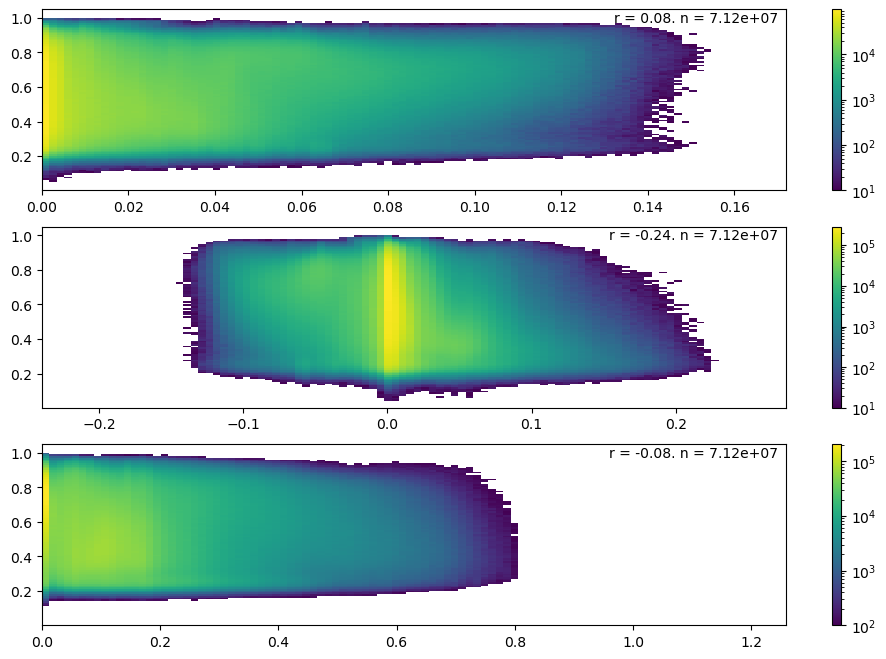

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (12, 8))

h = axes[0].hist2d(cummelts[cummelts>0], cors[cummelts>0], bins = 100, norm = mpl.colors.LogNorm(), cmin = 10)
_, r, n = get_stats(cummelts, cors)
axes[0].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[0].transAxes)
axes[0].set_ylim(top = 1.05)
plt.colorbar(h[3])

h = axes[1].hist2d(dswes, cors, bins = 100, norm = mpl.colors.LogNorm(), cmin = 10)
_, r, n = get_stats(dswes, cors)
axes[1].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[1].transAxes)
axes[1].set_ylim(top = 1.05)
plt.colorbar(h[3])

h = axes[2].hist2d(swes, cors, bins = 100, norm = mpl.colors.LogNorm(), cmin = 100)
_, r, n = get_stats(swes, cors)
axes[2].text(0.99, 0.99, f'r = {r:.2f}. n = {n:.2e}', va = 'top', ha = 'right', transform = axes[2].transAxes)
axes[2].set_ylim(top = 1.05)
plt.colorbar(h[3])